In [32]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [33]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [34]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
%%time

twitter_df = spark.read.parquet('gs://file-name')


CPU times: user 4.85 ms, sys: 93 µs, total: 4.94 ms
Wall time: 7.11 s


In [6]:
twitter_df.count()

16863979

In [7]:
original = twitter_df.withColumn("retweeted_status", when(twitter_df.retweeted_status.isNull(), twitter_df.retweeted_status))

In [8]:
original

text,Organization,id,retweeted_status
rt @sahealth: twi...,Other,1453450037011181568,null
cigarette sales i...,Other,1453450036793257984,null
rt @nytimes: merc...,Influencer,1453450037481115650,null
rt @billgates: go...,Other,1453450037757833218,null
rt @carlossimanca...,Other,1453450037946634240,null
post covid? we ar...,Other,1453450039121039360,null
rt @angie_rasmuss...,Other,1453450039439863820,null
rt @pn_1984: we a...,Other,1453450040605880327,null
@sharla_evans @hu...,Other,1453450040685518857,null
.@govchrissununu ...,Other,1453450041692200960,null


In [36]:
gov_raw = original.filter(original.Organization == 'Government')

In [37]:
gov_raw

text,Organization,id,retweeted_status
rt @breaking911: ...,Government,1452701786658283535,null
#moldova has laun...,Government,1452701884100263949,null
rt @leagueofcitie...,Government,1455978282973806594,null
new jersey #covid...,Government,1453042799792820233,null
rt @care: compoun...,Government,1453042939538587657,null
heading to the mo...,Government,1453042992227311617,null
rt @rosemarybayer...,Government,1453042993833791492,null
rt @pib_india: #c...,Government,1455778982561939471,null
#covid19 update ...,Government,1455779392831963139,null
#covid19 underlin...,Government,1449138262832975872,null


In [38]:
gov_raw2 = gov_raw.select(['text'])

In [39]:
gov_raw2.printSchema()

root
 |-- text: string (nullable = true)



In [40]:
text = gov_raw2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [41]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
[‼️ last chance t...,1421
[rt @govuganda: t...,1422
[rt @unece: citie...,1423
[rt @aaijamairpor...,1424
[rt @imphalrob: c...,1425


In [42]:
df_text.count()

38618

In [43]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @breaking911:, #breaking:, u.s., to, require, vaccine, passports,, covid, tests, when, international, restrictions, lift, next, month, https://t.co/k…]",0
1,"[#moldova, has, launched, national, campaign, to, boost, covid-19, vaccines, this, week, protect, yourself,, your, family,, you…, https://t.co/jmo3etsbfn]",1
2,"[rt, @leagueofcities:, yesterday,, children, ages, 5-11, years, old, became, eligible, for, the, first, covid-19, vaccine, with, the, approval, of, the, pfizer-…]",2
3,"[new, jersey, #covid19, update:\n➡️1,211, new, positive, pcr, tests, \n➡️1,036,496, total, positive, pcr, tests\n➡️382, new, positive…, https://t.co/ua1reabkpb]",3
4,"[rt, @care:, compounded, by, #covid19, and, #vaccine, inequity,, the, severity, of, the, climate, crisis, has, taken, an, unprecedented, toll, on, poorer, countr…]",4


In [44]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [45]:
df_tokens.count()

38618

In [46]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [47]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[rt, @breaking911:, #breaking:, u.s., to, require, vaccine, passports,, covid, tests, when, international, restrictions, lift, next, month, https://t.co/k…]",0,"(0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[#moldova, has, launched, national, campaign, to, boost, covid-19, vaccines, this, week, protect, yourself,, your, family,, you…, https://t.co/jmo3etsbfn]",1,"(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, @leagueofcities:, yesterday,, children, ages, 5-11, years, old, became, eligible, for, the, first, covid-19, vaccine, with, the, approval, of, the, pfizer-…]",2,"(3.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[new, jersey, #covid19, update:\n➡️1,211, new, positive, pcr, tests, \n➡️1,036,496, total, positive, pcr, tests\n➡️382, new, positive…, https://t.co/ua1reabkpb]",3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, @care:, compounded, by, #covid19, and, #vaccine, inequity,, the, severity, of, the, climate, crisis, has, taken, an, unprecedented, toll, on, poorer, countr…]",4,"(2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [48]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [49]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
502,"[children, young ...","[children,, young...","(84479,[3,4,6,15,...","[[4045642.0], [4...."
656,[#maharashtra #co...,"[#maharashtra, #c...","(84479,[7,10,32,2...","[[1.24292658E8], ..."
1055,[rt @shaunalshatt...,"[rt, @shaunalshat...","(84479,[0,1,2,9,1...","[[4.7945584E7], [..."
1480,[rt @tonyhinton20...,"[rt, @tonyhinton2...","(84479,[0,2,7,9,1...","[[4.7945584E7], [..."
1921,[rt @aaiidrairpor...,"[rt, @aaiidrairpo...","(84479,[2,8,18,43...","[[1.19094037E8], ..."


In [50]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [51]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.117647,10276,23981,"(modern famines are a direct result of conflict; #climatechange and the #covid19 pandemic are now compounding the ch… https://t.co/pmiinibpne,)","(modern famines are a direct result of conflict; #climatechange and the #covid19 pandemic are now compounding the ch… https://t.co/r04wrzzmam,)"
1,0.000000,17993,23832,"(rt @narendramodi: review meet with districts where covid-19 vaccination could pick pace. https://t.co/tregpnl3bc,)","(rt @narendramodi: review meet with districts where covid-19 vaccination could pick pace. https://t.co/tregpnl3bc,)"
2,0.476190,3170,35637,"(covid-19 report for 23rd october\n\nnew positive cases: 447\nof which 0-18 years: 78\nin quarantine: 260\nlocal contacts… https://t.co/xrif8urdkn,)","(covid-19 report for 29th october\n\nnew positive cases: 374\nof which 0-18 years: 65\nin quarantine: 218\nlocal contacts… https://t.co/2as4j0qdor,)"
3,0.315789,5828,6518,"(rt @mygovindia: the government will launch door-to-door covid-19 vaccination drive - #harghardastak to boost the second dose vaccination. l…,)","(the government will launch door-to-door covid-19 vaccination drive - #harghardastak to boost the second dose vaccin… https://t.co/4z3jvfenzz,)"
4,0.434783,8480,17995,"(covid-19 update \n\n▪️ 105.43 vaccine doses have been administered so far\n \n▪️ 3,36,41,175 total recoveries across th… https://t.co/jlhguvet49,)","(covid-19 update \n\n✅106.14 cr vaccine doses have been administered so far\n \n✅ 3,36,55,842 total recoveries across th… https://t.co/j6l5u9kfl2,)"


In [52]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  38618
Duplicate titles based on { 0.5 } jaccard distance:  13974
Unique titles based on { 0.5 } jaccard distance:  0.5 :  24644


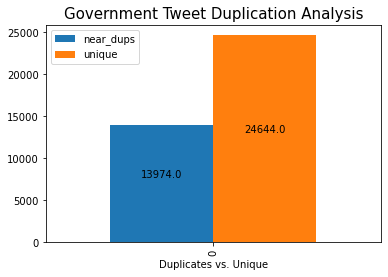

In [53]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Government Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 